# Imports and Configs

In [1]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import LabelEncoder
from optuna.samplers import TPESampler
from sklearn.utils import check_array
import matplotlib.pyplot as plt
from sklearn.base import clone
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import optuna
import glob

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
SEED = 27
N_FOLDS = 5
TARGET = 'Target'

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv', index_col='id')

In [4]:
label_encoder = LabelEncoder()

X = train.drop(TARGET, axis=1)
y = train[TARGET]
y = label_encoder.fit_transform(y)

# Loading OOF Files

In [5]:
def load_automl_oof_pred_probs(path):
    files = glob.glob(f'{path}/*.pkl')
    tmp = []
    for file in files:
        content = pickle.load(open(file, 'rb'))
        if type(content) == pd.DataFrame:
            tmp.append(content.values)
        else:
            tmp.append(content)
    return np.vstack(tmp)

def load_automl_test_pred_probs(path):
    files = glob.glob(f'{path}/*.csv')
    tmp = []
    for file in files:
        content = pd.read_csv(file, index_col="id")
        tmp.append(content.values)
    return np.mean(tmp, axis=0)

In [6]:
# Single Models
xgb_oof_pred_probs = pickle.load(open('/kaggle/input/academic-success-oof-files/single_models/oof_pred_probs/xgb_oof_pred_probs.pkl', 'rb'))
cb_oof_pred_probs = pickle.load(open('/kaggle/input/academic-success-oof-files/single_models/oof_pred_probs/cb_oof_pred_probs.pkl', 'rb'))
lgbm_oof_pred_probs = pickle.load(open('/kaggle/input/academic-success-oof-files/single_models/oof_pred_probs/lgbm_oof_pred_probs.pkl', 'rb'))
hgb_oof_pred_probs = pickle.load(open('/kaggle/input/academic-success-oof-files/single_models/oof_pred_probs/hgb_oof_pred_probs.pkl', 'rb'))
gb_oof_pred_probs = pickle.load(open('/kaggle/input/academic-success-oof-files/single_models/oof_pred_probs/gb_oof_pred_probs.pkl', 'rb'))
rf_oof_pred_probs = pickle.load(open('/kaggle/input/academic-success-oof-files/single_models/oof_pred_probs/rf_oof_pred_probs.pkl', 'rb'))

# AutoML
ag_oof_pred_probs = load_automl_oof_pred_probs('/kaggle/input/academic-success-oof-files/autogluon/oof_pred_probs')
laml_oof_pred_probs = load_automl_oof_pred_probs('/kaggle/input/academic-success-oof-files/laml/oof_pred_probs')
flaml_oof_pred_probs = load_automl_oof_pred_probs('/kaggle/input/academic-success-oof-files/flaml/oof_pred_probs')

In [7]:
# Single Models
xgb_test_pred_probs = pickle.load(open('/kaggle/input/academic-success-oof-files/single_models/test_pred_probs/xgb_test_pred_probs.pkl', 'rb'))
cb_test_pred_probs = pickle.load(open('/kaggle/input/academic-success-oof-files/single_models/test_pred_probs/cb_test_pred_probs.pkl', 'rb'))
lgbm_test_pred_probs = pickle.load(open('/kaggle/input/academic-success-oof-files/single_models/test_pred_probs/lgbm_test_pred_probs.pkl', 'rb'))
hgb_test_pred_probs = pickle.load(open('/kaggle/input/academic-success-oof-files/single_models/test_pred_probs/hgb_test_pred_probs.pkl', 'rb'))
gb_test_pred_probs = pickle.load(open('/kaggle/input/academic-success-oof-files/single_models/test_pred_probs/gb_test_pred_probs.pkl', 'rb'))
rf_test_pred_probs = pickle.load(open('/kaggle/input/academic-success-oof-files/single_models/test_pred_probs/rf_test_pred_probs.pkl', 'rb'))

# AutoML
ag_test_pred_probs = load_automl_test_pred_probs('/kaggle/input/academic-success-oof-files/autogluon/test_pred_probs')
laml_test_pred_probs = load_automl_test_pred_probs('/kaggle/input/academic-success-oof-files/laml/test_pred_probs')
flaml_test_pred_probs = load_automl_test_pred_probs('/kaggle/input/academic-success-oof-files/flaml/test_pred_probs')

# Defining Training and Cross Validation Functions

In [8]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit(self, X, y):
        print(f'Training {self.model.__class__.__name__}')

        rskf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)

        accs = []
        aucs = []
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        oof_preds = np.zeros(X.shape[0])
        for fold_idx, (train_idx, val_idx) in enumerate(rskf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)

            y_pred_probs = model.predict_proba(X_val)
            y_pred = np.argmax(y_pred_probs, axis=1)

            oof_pred_probs[val_idx] = y_pred_probs
            oof_preds[val_idx] = y_pred

            acc = accuracy_score(y_val, y_pred)
            auc = roc_auc_score(y_val, y_pred_probs, multi_class='ovo')
            accs.append(acc)
            aucs.append(auc)

            print(f'--- Fold {fold_idx + 1} - Accuracy: {acc:.6f}, AUC: {auc:.6f}')

        print(f'\n------ Accuracy: {np.mean(accs):.6f} ± {np.std(accs):.6f}')
        print(f'------ AUC:      {np.mean(aucs):.6f} ± {np.std(aucs):.6f}\n\n')

        return oof_pred_probs, oof_preds, accs, aucs
    
    def fit_predict_proba(self, X, y, X_test):            
        model = clone(self.model)
        model.fit(X, y)
        return model.predict_proba(X_test)

In [9]:
def save_submission(pred_probs, accuracy, auc, name):
    submission = pd.read_csv('/kaggle/input/playground-series-s4e6/sample_submission.csv')
    submission['Target'] = np.argmax(pred_probs, axis=1)
    submission['Target'] = label_encoder.inverse_transform(submission['Target'])
    submission.to_csv(f'{name}_acc-{accuracy:.6f}_auc-{auc:.6f}.csv', index=False)
    return submission

In [10]:
accuracies = {}
aucs = {}

test_pred_probs = {}
oof_pred_probs = {}
oof_preds = {}

# Base Models

In [11]:
oof_pred_probs['XGB'] = xgb_oof_pred_probs
test_pred_probs['XGB'] = xgb_test_pred_probs
accuracies['XGB'] = [0.836644, 0.837101, 0.835403, 0.833235, 0.825590]
aucs['XGB'] = [0.930521, 0.932307, 0.929514, 0.929363, 0.924143]

In [12]:
oof_pred_probs['CB'] = cb_oof_pred_probs
test_pred_probs['CB'] = cb_test_pred_probs
accuracies['CB'] = [0.836448, 0.836513, 0.834618, 0.833366, 0.826962]
aucs['CB'] = [0.930153, 0.931919, 0.929599, 0.929235, 0.924700]

In [13]:
oof_pred_probs['LGBM'] = lgbm_oof_pred_probs
test_pred_probs['LGBM'] = lgbm_test_pred_probs
accuracies['LGBM'] = [0.837036, 0.836317, 0.836579, 0.834804, 0.826635]
aucs['LGBM'] = [0.930935, 0.932722, 0.930180, 0.930146, 0.924594]

In [14]:
oof_pred_probs['HGB'] = hgb_oof_pred_probs
test_pred_probs['HGB'] = hgb_test_pred_probs
accuracies['HGB'] = [0.834814, 0.835010, 0.835403, 0.832517, 0.825132]
aucs['HGB'] = [0.929074, 0.930172, 0.928571, 0.928758, 0.924181]

In [15]:
oof_pred_probs['GB'] = gb_oof_pred_probs
test_pred_probs['GB'] = gb_test_pred_probs
accuracies['GB'] = [0.836448, 0.835664, 0.835795, 0.833235, 0.823629]
aucs['GB'] = [0.930418, 0.931982, 0.930053, 0.929623, 0.925156]

In [16]:
oof_pred_probs['RF'] = rf_oof_pred_probs
test_pred_probs['RF'] = rf_test_pred_probs
accuracies['RF'] = [0.828738, 0.831939, 0.830306, 0.826766, 0.821865]
aucs['RF'] = [0.923348, 0.925072, 0.921366, 0.923187, 0.917795]

In [17]:
oof_pred_probs['AG'] = ag_oof_pred_probs
test_pred_probs['AG'] = ag_test_pred_probs
accuracies['AG'] = [0.835010, 0.835860, 0.835403, 0.833823, 0.826113]
aucs['AG'] = [0.930343, 0.931906, 0.929550, 0.929920, 0.925213]

In [18]:
oof_pred_probs['LAML'] = laml_oof_pred_probs
test_pred_probs['LAML'] = laml_test_pred_probs
accuracies['LAML'] = [0.835403, 0.835010, 0.833900, 0.832190, 0.826243]
aucs['LAML'] = [0.931167, 0.932128, 0.929940, 0.929787, 0.924839]

In [19]:
oof_pred_probs['FLAML'] = flaml_oof_pred_probs
test_pred_probs['FLAML'] = flaml_test_pred_probs
accuracies['FLAML'] = [0.835272, 0.835010, 0.835925, 0.834608, 0.823499]
aucs['FLAML'] = [0.930438, 0.932135, 0.930229, 0.930079, 0.924522]

# Ensemble

In [20]:
def objective(trial):
    xgb_weight = trial.suggest_float('xgb_weight', 0.0, 1.0)
    cb_weight = trial.suggest_float('cb_weight', 0.0, 1.0)
    lgbm_weight = trial.suggest_float('lgbm_weight', 0.0, 1.0)
    hgb_weight = trial.suggest_float('hgb_weight', 0.0, 1.0)
    gb_weight = trial.suggest_float('gb_weight', 0.0, 1.0)
    rf_weight = trial.suggest_float('rf_weight', 0.0, 1.0)
    ag_weight = trial.suggest_float('ag_weight', 0.0, 1.0)
    laml_weight = trial.suggest_float('laml_weight', 0.0, 1.0)
    flaml_weight = trial.suggest_float('flaml_weight', 0.0, 1.0)

    weights = [
        xgb_weight,
        cb_weight,
        lgbm_weight,
        hgb_weight,
        gb_weight,
        rf_weight,
        ag_weight,
        laml_weight,
        flaml_weight
    ]
    weights /= np.sum(weights)
    
    pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
    for model, weight in zip(oof_pred_probs.keys(), weights):
        pred_probs += oof_pred_probs[model] * weight

    preds = np.argmax(pred_probs, axis=1)

    return accuracy_score(y, preds)


tune_ensemble_weights = False
if tune_ensemble_weights:
    sampler = TPESampler(seed=SEED, n_startup_trials=10)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(objective, n_trials=1000, n_jobs=-1)
    best_weights = study.best_params
else:
    best_weights = {
        'xgb_weight': 0.32848164825087656, 
        'cb_weight': 0.7605000681431924, 
        'lgbm_weight': 0.8646798750739314, 
        'hgb_weight': 0.08715090241113871, 
        'gb_weight': 0.29442701953208905, 
        'rf_weight': 0.25206140981047864, 
        'ag_weight': 0.00045551712601656145, 
        'laml_weight': 0.01695972301717404, 
        'flaml_weight': 0.01781262444356089
    }

model_prefixes = ['xgb', 'cb', 'lgbm', 'hgb', 'gb', 'rf', 'ag', 'laml', 'flaml']
best_weights = [best_weights[f'{model}_weight'] for model in model_prefixes]
best_weights /= np.sum(best_weights)

In [21]:
ensemble_oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
for model, weight in zip(oof_pred_probs.keys(), best_weights):
    ensemble_oof_pred_probs += oof_pred_probs[model] * weight

ensemble_oof_preds = np.argmax(ensemble_oof_pred_probs, axis=1)
ensemble_acc = accuracy_score(y, ensemble_oof_preds)
ensemble_auc = roc_auc_score(y, ensemble_oof_pred_probs, multi_class='ovo')

oof_pred_probs['Ensemble'] = ensemble_oof_pred_probs
accuracies['Ensemble'] = [ensemble_acc] * N_FOLDS
aucs['Ensemble'] = [ensemble_auc] * N_FOLDS

In [22]:
final_pred_probs = np.zeros((test.shape[0], len(np.unique(y))))
for model, weight in zip(test_pred_probs.keys(), best_weights):
    final_pred_probs += test_pred_probs[model] * weight
    
ensemble_preds = np.argmax(final_pred_probs, axis=1)

In [23]:
ensemble_sub = save_submission(final_pred_probs, ensemble_acc, ensemble_auc, "ensemble")
ensemble_sub.head()

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Graduate
4,76522,Enrolled


# Stacking

In [24]:
# Reference: https://www.kaggle.com/competitions/playground-series-s4e6/discussion/509353#2851035
class PassThroughClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, idx_cols):
        self.idx_cols = idx_cols
        self.is_fitted_ = True

    def fit(self, X, y=None):
        return self

    def predict_proba(self, X):
        return check_array(X)[:, self.idx_cols]


X_oof_pred_probs = np.log(pd.DataFrame(np.hstack(list(oof_pred_probs.values()))) + 1e-7)
X_test_pred_probs = np.log(pd.DataFrame(np.hstack(list(test_pred_probs.values()))) + 1e-7)

estimators = [
    ('XGB', PassThroughClassifier(list(range(3)))),
    ('CB', PassThroughClassifier(list(range(3, 6)))),
    ('LGBM', PassThroughClassifier(list(range(6, 9)))),
    ('HGB', PassThroughClassifier(list(range(9, 12)))),
    ('GB', PassThroughClassifier(list(range(12, 15)))),
    ('RF', PassThroughClassifier(list(range(15, 18)))),
    ('AG', PassThroughClassifier(list(range(18, 21)))),
    ('LAML', PassThroughClassifier(list(range(21, 24)))),
    ('FLAML', PassThroughClassifier(list(range(24, 27))))
]

In [25]:
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'random_state': SEED,
        'verbose': -1
    }

    final_estimator = LGBMClassifier(**params)
    model = StackingClassifier(estimators, cv='prefit', n_jobs=-1, final_estimator=final_estimator)
    trainer = Trainer(model)
    _, _, accs, _ = trainer.fit(X_oof_pred_probs, y)
    return np.mean(accs)


tune_final_estimator = False
if tune_final_estimator:
    sampler = TPESampler(seed=SEED)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(objective, n_trials=1000, catch=(ValueError,), n_jobs=-1)
    fe_params = study.best_params
    fe_params['random_state'] = SEED
    fe_params['n_jobs'] = -1
    fe_params['verbose'] = -1
    print(study.best_params)
else:
    fe_params = {
        'num_leaves': 66, 
        'learning_rate': 0.0014531938331513146, 
        'n_estimators': 1600,
        'colsample_bytree': 0.22709450802249748,
        'reg_alpha': 6.817827989713506, 
        'reg_lambda': 5.734297274885133,
        'verbose': -1,
        'n_jobs': -1,
        'random_state': SEED
    }

In [26]:
# LogisticRegression 0.834967
# LGBMClassifier

final_estimator = LGBMClassifier(**fe_params)
stacking_model = StackingClassifier(estimators, cv='prefit', n_jobs=-1, final_estimator=final_estimator)
stacking_trainer = Trainer(stacking_model)
stacking_oof_pred_probs, stacking_oof_preds, stacking_accs, stacking_aucs = stacking_trainer.fit(X_oof_pred_probs, y)
oof_pred_probs['Stacking'] = stacking_oof_pred_probs
test_pred_probs['Stacking'] = stacking_trainer.fit_predict_proba(X_oof_pred_probs, y, X_test_pred_probs)
accuracies['Stacking'] = stacking_accs
aucs['Stacking'] = stacking_aucs

Training StackingClassifier
--- Fold 1 - Accuracy: 0.838931, AUC: 0.930804
--- Fold 2 - Accuracy: 0.835991, AUC: 0.932507
--- Fold 3 - Accuracy: 0.837559, AUC: 0.930002
--- Fold 4 - Accuracy: 0.835522, AUC: 0.929912
--- Fold 5 - Accuracy: 0.827289, AUC: 0.924720

------ Accuracy: 0.835058 ± 0.004067
------ AUC:      0.929589 ± 0.002607




In [27]:
stacking_sub = save_submission(test_pred_probs['Stacking'], np.mean(accuracies['Stacking']), np.mean(aucs['Stacking']), "stacking")
stacking_sub.head()

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Graduate
4,76522,Enrolled


# Visualizing The Results

In [28]:
accuracies = pd.DataFrame(accuracies)
aucs = pd.DataFrame(aucs)

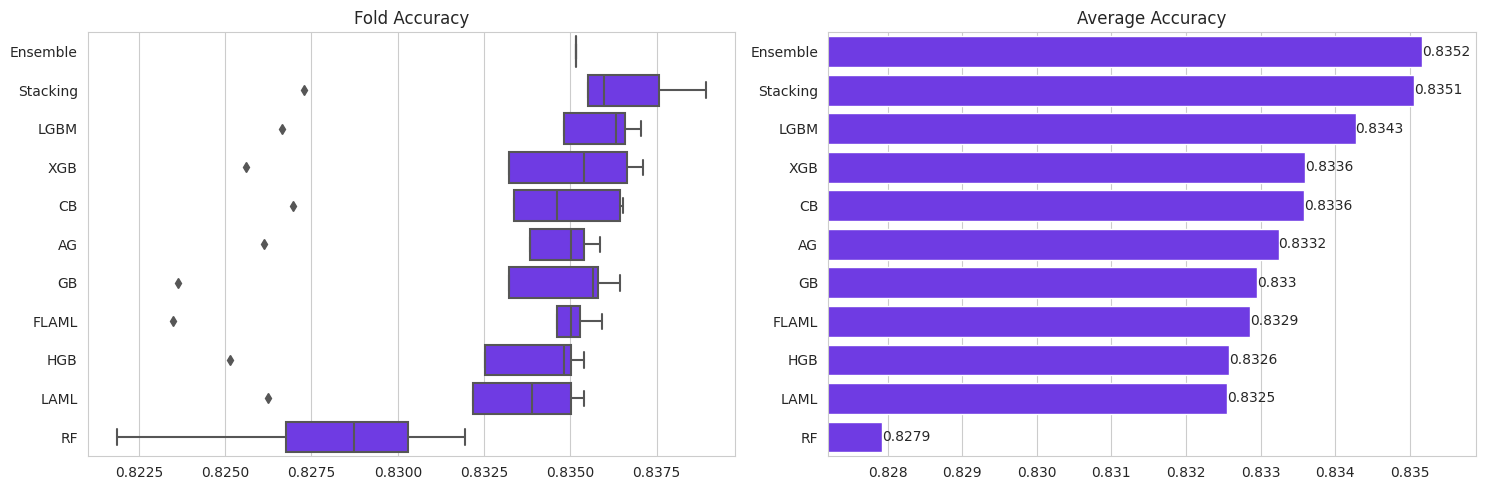

In [29]:
mean_accs = accuracies.mean().sort_values(ascending=False)
order = accuracies.mean().sort_values(ascending=False).index.tolist()

min_acc = mean_accs.min()
max_acc = mean_accs.max()
padding = (max_acc - min_acc) * 0.1
lower_limit = min_acc - padding
upper_limit = max_acc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=accuracies, order=order, ax=axs[0], orient='h', color='#651FFF')
axs[0].set_title('Fold Accuracy')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_accs.values, y=mean_accs.index, ax=axs[1], color='#651FFF')
axs[1].set_title('Average Accuracy')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_accs.values):
    barplot.text(score, i, round(score, 4), va='center')

plt.tight_layout()
plt.show()

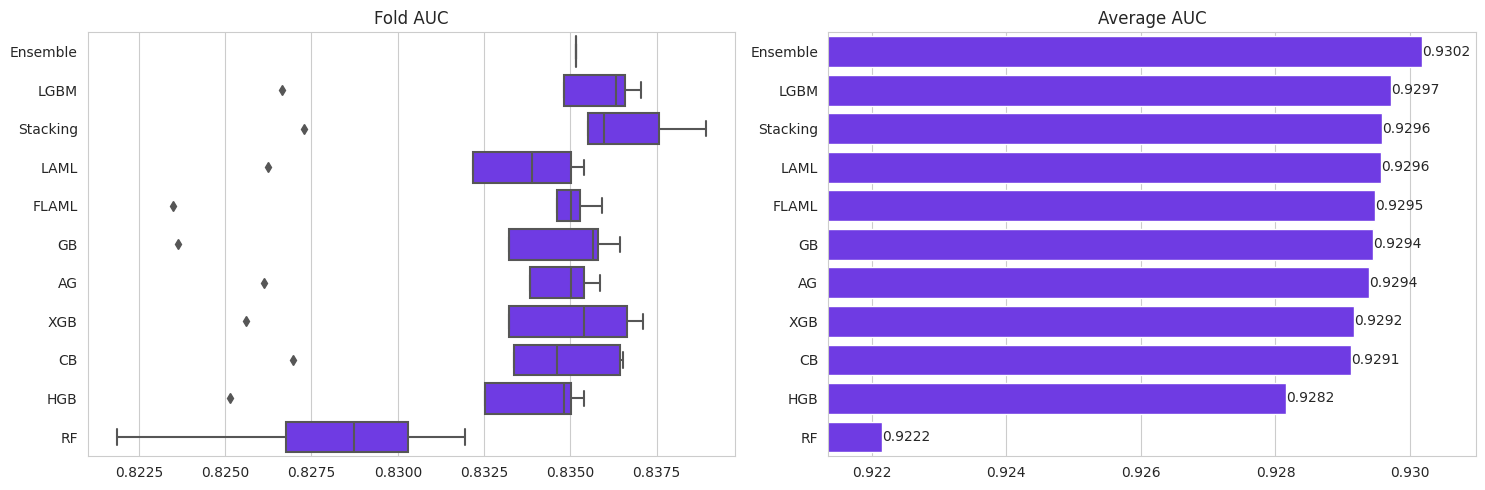

In [30]:
mean_aucs = aucs.mean().sort_values(ascending=False)
order = aucs.mean().sort_values(ascending=False).index.tolist()

min_auc = mean_aucs.min()
max_auc = mean_aucs.max()
padding = (max_auc - min_auc) * 0.1
lower_limit = min_auc - padding
upper_limit = max_auc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=accuracies, order=order, ax=axs[0], orient='h', color='#651FFF')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_aucs.values, y=mean_aucs.index, ax=axs[1], color='#651FFF')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_aucs.values):
    barplot.text(score, i, round(score, 4), va='center')

plt.tight_layout()
plt.show()